In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


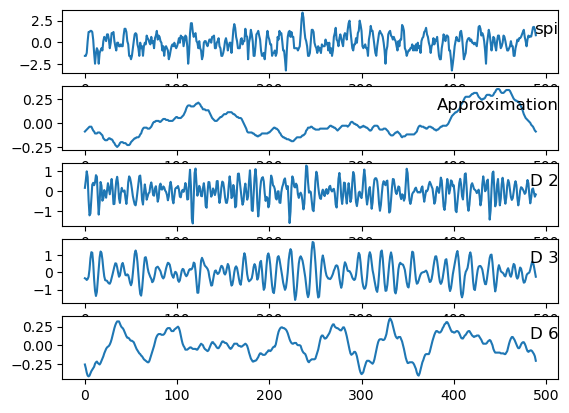

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('wavelet_kesinga.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0,1,3,4,7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [3]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [4]:
# load dataset
dataset = read_csv('wavelet_kesinga.csv', header=0, index_col=0)
dataset=dataset.drop(['D 1','D 4','D 5'], axis=1)


In [5]:
dataset

,spi,Approximation,D 2,D 3,D 6
sl.no,,,,,
1,-1.54,-0.09,0.17,-0.34,-0.26
2,-1.54,-0.08,0.55,-0.37,-0.31
3,-1.20,-0.07,0.99,-0.44,-0.37
4,0.15,-0.06,0.71,-0.38,-0.41
5,1.20,-0.05,-0.42,-0.25,-0.42
...,...,...,...,...,...
486,1.18,-0.03,0.10,0.62,-0.08
487,1.75,-0.04,0.14,0.60,-0.10
488,1.79,-0.06,-0.07,0.35,-0.12


In [6]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5,7,9,8]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var2(t)
1   0.252632   0.266667   0.614583   0.373529  0.283333
2   0.252632   0.283333   0.746528   0.364706  0.300000
3   0.303759   0.300000   0.899306   0.344118  0.316667
4   0.506767   0.316667   0.802083   0.361765  0.333333
5   0.664662   0.333333   0.409722   0.400000  0.350000


In [7]:

# split into train and test sets
values = reframed.values
n_train_hours = 365
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 1, 4) (365,) (124, 1, 4) (124,)


In [8]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=80, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Epoch 1/80
6/6 [==============================] - 3s 131ms/step - loss: 0.3258 - val_loss: 0.6200
Epoch 2/80
6/6 [==============================] - 0s 10ms/step - loss: 0.2758 - val_loss: 0.5624
Epoch 3/80
6/6 [==============================] - 0s 8ms/step - loss: 0.2278 - val_loss: 0.5041
Epoch 4/80
6/6 [==============================] - 0s 9ms/step - loss: 0.1838 - val_loss: 0.4455
Epoch 5/80
6/6 [==============================] - 0s 12ms/step - loss: 0.1488 - val_loss: 0.3883
Epoch 6/80
6/6 [==============================] - 0s 10ms/step - loss: 0.1261 - val_loss: 0.3381
Epoch 7/80
6/6 [==============================] - 0s 9ms/step - loss: 0.1163 - val_loss: 0.3010
Epoch 8/80
6/6 [==============================] - 0s 10ms/step - loss: 0.1160 - val_loss: 0.2804
Epoch 9/80
6/6 [==============================] - 0s 10ms/step - loss: 0.1180 - val_loss: 0.2698
Epoch 10/80
6/6 [==============================] - 0s 11ms/step - loss: 0.1185 - val_loss: 0.2663
Epoch 11/80
6/6 [==============

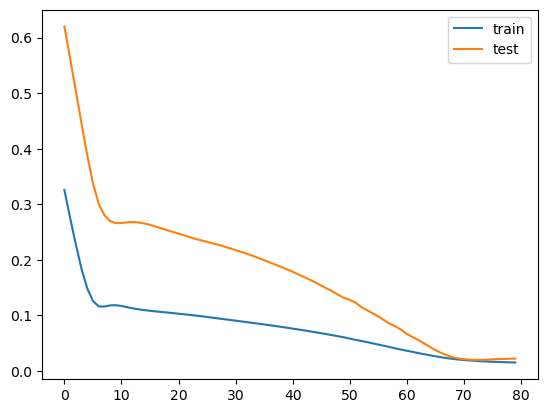

In [9]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
final_predictions = model.predict(test_X)
print(final_predictions.shape)

4/4 [==============================] - 0s 5ms/step
(124, 1)


In [13]:
import numpy as np
import pandas as pd
prediction = pd.DataFrame(final_predictions, columns=['predictions']).to_csv('prediction.csv')
# test_X = pd.DataFrame(test_X, columns=['test_X']).to_csv('test_X.csv')

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_evaluation_metrics(y_observed, y_predicted):
     # Convert to NumPy arrays if they are lists
    if isinstance(y_observed, list):
        y_observed = np.array(y_observed)
    if isinstance(y_predicted, list):
        y_predicted = np.array(y_predicted)
        
    metrics = {}

    # Calculate ME (Mean Error)
    metrics['ME'] = np.mean(y_observed - y_predicted)

    # Calculate MAE (Mean Absolute Error)
    metrics['MAE'] = mean_absolute_error(y_observed, y_predicted)

    # Calculate MSE (Mean Squared Error)
    metrics['MSE'] = mean_squared_error(y_observed, y_predicted)

    # Calculate RMSE (Root Mean Squared Error)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # Calculate NRMSE (Normalized Root Mean Squared Error)
    metrics['NRMSE'] = metrics['RMSE'] / (np.max(y_observed) - np.min(y_observed))

    # Calculate PBIAS (Percent Bias)
    metrics['PBIAS'] = np.mean(100 * (y_observed - y_predicted) / np.mean(y_observed))

    # Calculate RSR (Root Mean Square Ratio)
    metrics['RSR'] = metrics['RMSE'] / np.std(y_observed)

    # Calculate rSD (Ratio of the Standard Deviation)
    metrics['rSD'] = np.std(y_observed - y_predicted) / np.std(y_observed)

    # Calculate NSE (Nash-Sutcliffe Efficiency)
    metrics['NSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))/2000

    # Calculate mNSE (Modified Nash-Sutcliffe Efficiency)
    metrics['mNSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))/2000

    # Calculate rNSE (Relative Nash-Sutcliffe Efficiency)
    metrics['rNSE'] = metrics['NSE'] / np.var(y_observed)

    # Calculate d (Index of Agreement)
    metrics['d'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                       np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate md (Modified d Index)
    metrics['md'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate rd (Relative d Index)
    metrics['rd'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate cp (Coefficient of Performance)
    metrics['cp'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                         np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate r (Index of Agreement)
    metrics['r'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                        np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate R2 (Coefficient of Determination)
    metrics['R2'] = r2_score(y_observed, y_predicted)

    return metrics


In [15]:
evaluation_metrics = calculate_evaluation_metrics(test_y, final_predictions)
print(evaluation_metrics)

{'ME': -0.009853081, 'MAE': 0.022440707, 'MSE': 0.0007329018, 'RMSE': 0.02707216, 'NRMSE': 0.03691658, 'PBIAS': -1.4770701, 'RSR': 0.10793921, 'rSD': 1.4356086, 'NSE': 0.8721240386962891, 'mNSE': 0.8721240386962891, 'rNSE': 13.86407792958125, 'd': 0.46208345890045166, 'md': 0.46208345890045166, 'rd': 0.46208345890045166, 'cp': 0.46208345890045166, 'r': 0.46208345890045166, 'R2': 0.988349125305659}


In [ ]:
final_predictions = model.predict(test_X)
print(final_predictions.shape)

In [19]:
# pd.DataFrame(train_y).to_csv('/content/actualTrainLSTM .csv', index=False, header=False)
# pd.DataFrame(trainPredict).to_csv('/content/predictTrainLSTM .csv', index=False, header=False)
# pd.DataFrame(test_X).to_csv('/content/actualTestLSTM.csv', index=False, header=False)
pd.DataFrame(final_predictions).to_csv('predictTestLSTM.csv', index=False,header=False)

In [22]:
test_y

array([0.35      , 0.35      , 0.3333333 , 0.3333333 , 0.31666666,
       0.31666666, 0.3333333 , 0.35      , 0.35      , 0.35      ,
       0.3333333 , 0.3333333 , 0.31666666, 0.29999998, 0.29999998,
       0.28333333, 0.29999998, 0.29999998, 0.31666666, 0.3333333 ,
       0.35      , 0.35      , 0.36666667, 0.36666667, 0.36666667,
       0.36666667, 0.36666667, 0.38333333, 0.39999998, 0.43333334,
       0.46666664, 0.5       , 0.5333333 , 0.54999995, 0.56666666,
       0.5833333 , 0.59999996, 0.59999996, 0.6166667 , 0.6333333 ,
       0.65      , 0.6833333 , 0.73333335, 0.75      , 0.7833333 ,
       0.8166666 , 0.84999996, 0.8666667 , 0.8666667 , 0.8666667 ,
       0.8666667 , 0.8666667 , 0.8833333 , 0.9       , 0.9166666 ,
       0.9166666 , 0.9333333 , 0.9333333 , 0.9333333 , 0.9333333 ,
       0.9       , 0.8666667 , 0.84999996, 0.8333333 , 0.8166666 ,
       0.8166666 , 0.8333333 , 0.8333333 , 0.84999996, 0.8833333 ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.88333

In [24]:
# Convert the array to a DataFrame
df = pd.DataFrame(test_y.reshape(test_y.shape[0], -1), columns=['Column 1'])

# Save DataFrame to CSV
df.to_csv('array_data.csv', index=False)
